In [155]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

In [156]:
training_points = multivariate_normal.rvs(size=(10,2))
# training_points =  np.array(
#     [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0], 
#     [1.0, 0.5], [0.5, 1.0], [1.0, 0.25], [0.25, 1.0],
#     [0.5, 0.25], [0.25, 0.0], [0.25, 0.5],
#     [0.0, 0.5], [0.5, 0.0], [0.5, 0.5]]
# )

# training_points = np.array(
#     [[0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [2.0, 2.0]]
# )

# df = pd.DataFrame(training_points)
# df.to_csv('training_points_causing_problem.csv')

# df = pd.read_csv("training_points_causing_problem.csv") 
# training_points = df.values[:,1:]

In [157]:
training_points

array([[-0.62591647, -1.05713138],
       [-0.20677954, -0.48945424],
       [ 0.60392023, -1.01578056],
       [ 0.17554079, -0.2187303 ],
       [ 0.31503675, -1.55080936],
       [ 0.15155799, -0.09623218],
       [-0.18532866, -0.14435723],
       [-0.17521432, -0.69103445],
       [ 1.76141203,  0.35928538],
       [ 0.47637378, -0.95718262]])

In [158]:

class RarePatternDetect:
    def __init__(self, training_set: np.array, min_area: float):
        self.training_set = training_set # a N x d matrix
        self.min_area = min_area # the smallest allowed area
        self.N, self.d = self.training_set.shape
        self.Nrange, self.drange = (range(x) for x in self.training_set.shape)
        self.largest_bounding_area = np.array(
            [
                [
                    np.min(self.training_set[:,0])-0.01,
                    np.min(self.training_set[:,1])-0.01
                ], 
                [
                    np.max(self.training_set[:,0])+0.01,
                    np.max(self.training_set[:,1])+0.01
                ]
            ]
        )
        self.model = self.create_model()
           
    
    def create_model(self):
        def _pattern_area():
            return pyo.prod(model.interval_lengths[i] for i in self.drange)

        # define model
        model = pyo.ConcreteModel()

        ## variables
        # x is a 2d vector
        # model.d_dimension = pyo.Set(initialize=self.drange)
        # model.d_dimension = pyo.Set(initialize=self.drange)
        # model.matrix = pyo.Set(initialize=(model.d_dimension * model.d_dimension)) # range(2))

        # model.d_dimension = pyo.Set(initialize=self.drange)
        # model.matrix = pyo.Set(initialize=model.d_dimension * model.d_dimension)
        #model.matrix = pyo.Set(initialize=self.drange)

        def adjust_largest_pattern_bounds(model, i, j):
            print("adjust_largest_pattern_bounds: ", i) 
            min_b = np.min(self.training_set[:,i])
            max_b = np.max(self.training_set[:,i])
            return min_b, max_b

        model.pattern = pyo.Var(self.drange , self.drange, bounds=adjust_largest_pattern_bounds)
        #model.pattern = pyo.Var(model.matrix , bounds=adjust_largest_pattern_bounds)

        # TODO: simplify with np.apply_along_axis
        # def _adjust_largest_pattern_bounds(model, i, j):
            # print("i,j: ",i,j)
            # if (i, j) == (0, 0):
            #     min_b = np.min(self.training_set[i, :])
            #     max_b = np.max(self.training_set[i, :])
            # elif (i, j) == (0, 1):
            #     min_b = np.min(self.training_set[i, :])
            #     max_b = np.max(self.training_set[i, :])
            # elif (i, j) == (1, 0):
            #     min_b = np.min(self.training_set[j, :])
            #     max_b = np.max(self.training_set[j, :])
            # else:  # (1,1)
            #     min_b = np.min(self.training_set[j, :])
            #     max_b = np.max(self.training_set[j, :])
            # return (min_b, max_b)
        # model.pattern = pyo.Var(model.matrix, bounds=_adjust_largest_pattern_bounds)

        # def adjust_pattern_bounds(model, i, j): 
        #     min_b = np.min(self.training_set[:,i])
        #     max_b = np.max(self.training_set[:,i])
        #     return min_b, max_b

        # model.pattern = pyo.Var(model.matrix , bounds=adjust_pattern_bounds)

        # y is a boolean vector of size N
        model.included = pyo.Var(
            self.Nrange, within=pyo.Binary, initialize=0
        )

        # auxiliary variables
        model.interval_lengths = pyo.Var(
            self.drange, within=pyo.NonNegativeReals
        )
        model.point_left_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )
        model.point_right_of_pattern = pyo.Var(
            self.Nrange, self.drange, within=pyo.Binary, initialize=0
        )
        
        ## objective (minimised by default)
        model.obj = pyo.Objective(
            expr=sum(model.included[i] for i in self.Nrange)/_pattern_area(), 
            sense=pyo.minimize
        )

        ## constraints

        # pattern area needs to exceed min_area
        model.area_constraint = pyo.Constraint(
            expr=_pattern_area() >= self.min_area
        )

        # training points included in model.included lie within the pattern (NB: In principle we would need to ensure that points not included are also
        # not included in model.included. However, since including points outside the pattern increases the objective, this is covered.)

        model.include_constraint = pyo.ConstraintList()
        model.enforce_point_left_of_pattern = pyo.ConstraintList()
        model.enforce_point_right_of_pattern = pyo.ConstraintList()
        M = 100000
        for j in self.Nrange:
            for i in self.drange:
                # print("i: ",i)
                # enforcing auxiliary variables are correct: point_left_of_pattern[j,i] is True iff the jth training point lies strictly outside the pattern in ith dimension, etc.
                model.enforce_point_left_of_pattern.add(
                    (model.point_left_of_pattern[j, i]*M + self.training_set[j,i]) >=  model.pattern[0,i]
                )
                model.enforce_point_left_of_pattern.add(
                     self.training_set[j,i] + 1e-3 <=  (model.pattern[0,i] + (1-model.point_left_of_pattern[j, i])*M)
                )
                model.enforce_point_right_of_pattern.add(
                   self.training_set[j,i] <=  (model.pattern[1,i] + model.point_right_of_pattern[j, i]*M)
                )
                model.enforce_point_right_of_pattern.add(
                    ((1-model.point_right_of_pattern[j, i])*M + self.training_set[j,i]) >=  (model.pattern[1,i] + 1e-3)
                )

            model.include_constraint.add(
                # key bit: this constraint enforces that the model.included for jth point can be set to 0 only if the point is not contained in the pattern (as witnessed by the fact
                # that the corresponding auxiliary variables are all 0)
                model.included[j] + sum(model.point_right_of_pattern[j,i] + model.point_left_of_pattern[j,i] for i in self.drange)  >= 1
            )

        # connect auxiliary variables: interval lengths are differences of pattern points
        model.interval_constraint = pyo.ConstraintList()
        for i in self.drange:
            model.interval_constraint.add(
                model.interval_lengths[i] == model.pattern[1,i] - model.pattern[0,i]
            )

        # Adding a constraint on the pattern s.t
        model.pattern_constraint = pyo.ConstraintList()
        # x[0] + width < max_x
        model.pattern_constraint.add(
            expr= model.pattern[0,0] + model.interval_lengths[0] <= np.max(self.training_set[:,0])
        )
        # y[0] + height < max_y
        model.pattern_constraint.add(
            expr= model.pattern[1,0] + model.interval_lengths[1] <= np.max(self.training_set[:,1])
        )
        # set limit on min y and min x 
        # x[0] + width > min_y
        model.pattern_constraint.add(
            expr= model.pattern[0,0] >= np.min(self.training_set[:,0])
        )
        # y[0] + height < max_y
        model.pattern_constraint.add(
            expr= model.pattern[1,0] >= np.min(self.training_set[:,1])
        )

        return model

    def add_point_to_model(self, point):
        # point to be classified lies in pattern
        point = point.squeeze()
        assert point.shape == (2,)
        self.model.point_constraint = pyo.ConstraintList()
        for i in self.drange:
            # x[i] <= point[i] <= x[i + d], for all i
            self.model.point_constraint.add(self.model.pattern[0, i] <= point[i])
            self.model.point_constraint.add(point[i] <= self.model.pattern[1, i])

    def extract_points_included_in_pattern(self):
        included_points = []
        for i in self.model.included:
            if np.round(self.model.included[i].value,1) == 1.0:
                # print("included point index: ",i, self.training_set[i])
                included_points.append(self.training_set[i])
        return np.array(included_points)

    def extract_pattern(self):
        intervals = np.zeros((2,2), dtype=float)
        for _, j in enumerate(self.model.pattern):
            # print("pattern coordinate value: ", j, self.model.pattern[j].value)
            intervals[j] = self.model.pattern[j].value
        return intervals.T

    def classify(self, point_to_be_classified: np.array):
        self.add_point_to_model(point_to_be_classified) # point to be classified is a 1 x d array
        _ = pyo.SolverFactory('mindtpy').solve(self.model, strategy='OA', mip_solver='glpk', nlp_solver='ipopt', tee=True,)
        # self.model.display()
        return pyo.value(self.model.obj)

In [159]:
rare_pattern_detect = RarePatternDetect(training_points, min_area=0.1)
point_to_be_classified = np.array([0.2,0.3])
#point_to_be_classified = training_points[1]
print("training_points[1]: ", training_points[1])
print("point_to_be_classified: ", point_to_be_classified)
results = rare_pattern_detect.classify(point_to_be_classified)
intervals = rare_pattern_detect.extract_pattern()
largest_bounding_area = rare_pattern_detect.largest_bounding_area
included_points = rare_pattern_detect.extract_points_included_in_pattern()

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 101 constraints (1 nonlinear) and 0 disjunctions, with 56 variables, of which 50 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1
training_points[1]:  [-0.20677954 -0.48945424]
point_to_be_classified:  [0.2 0.3]


         -       Relaxed NLP       -9.7993e-07            inf    -9.7993e-07      nan%      0.20
         1              MILP      -1.94487e-06            inf    -9.7993e-07      nan%      0.24
NLP subproblem was locally infeasible.
Solving feasibility problem
MILP main problem is infeasible. Problem may have no more feasible binary configurations.
MindtPy exiting due to MILP main problem infeasibility.
 Primal integral          :       nan 
 Dual integral            :    0.0000 
 Primal-dual gap integral :       nan 


ERROR: evaluating object as numeric value: interval_lengths[0]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object interval_lengths[0]
ERROR: evaluating object as numeric value: obj
        (object: <class 'pyomo.core.base.objective.ScalarObjective'>)
    No value for uninitialized NumericValue object interval_lengths[0]


ValueError: No value for uninitialized NumericValue object interval_lengths[0]

In [ ]:
print(results, largest_bounding_area)

0.0 [[-1.60827543 -1.64028223]
 [ 0.45044087  0.73305149]]


In [ ]:
training_points

array([[ 0.07899456,  0.72305149],
       [ 0.09104343,  0.58198905],
       [-0.7561715 ,  0.15761645],
       [-0.69842946, -0.89000405],
       [ 0.44044087, -0.6922324 ],
       [-0.11238446,  0.67550132],
       [-1.32375532, -1.63028223],
       [ 0.14750104, -1.61357464],
       [-0.29252945,  0.02765122],
       [-1.59827543, -0.2503991 ]])

In [ ]:
rare_pattern_detect.model.display()

Model unknown

  Variables:
    pattern : Size=4, Index=pattern_index
        Key    : Lower               : Value               : Upper               : Fixed : Stale : Domain
        (0, 0) : -1.5982754251383695 : -0.7295393205343331 : 0.44044086590447395 : False : False :  Reals
        (0, 1) : -1.5982754251383695 :  0.2186485814659111 : 0.44044086590447395 : False : False :  Reals
        (1, 0) : -1.6302822290756185 : 0.34229958100399893 :  0.7230514861340531 : False : False :  Reals
        (1, 1) : -1.6302822290756185 : 0.45830881354584624 :  0.7230514861340531 : False : False :  Reals
    included : Size=10, Index=included_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   0.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : Fals

In [ ]:
# from io import StringIO 

# textbuffer = StringIO()
# for v in rare_pattern_detect.model.component_objects(pyo.Var):
#     v.pprint(textbuffer)
#     textbuffer.write('\n')

# for v in rare_pattern_detect.model.component_objects(pyo.Constraint):
#     v.pprint(textbuffer)
#     textbuffer.write('\n')

# for v in rare_pattern_detect.model.component_objects(pyo.Set):
#     v.pprint(textbuffer)
#     textbuffer.write('\n')


# with open('solver_log_2.txt', 'w') as outputfile:
#     outputfile.write(textbuffer.getvalue())

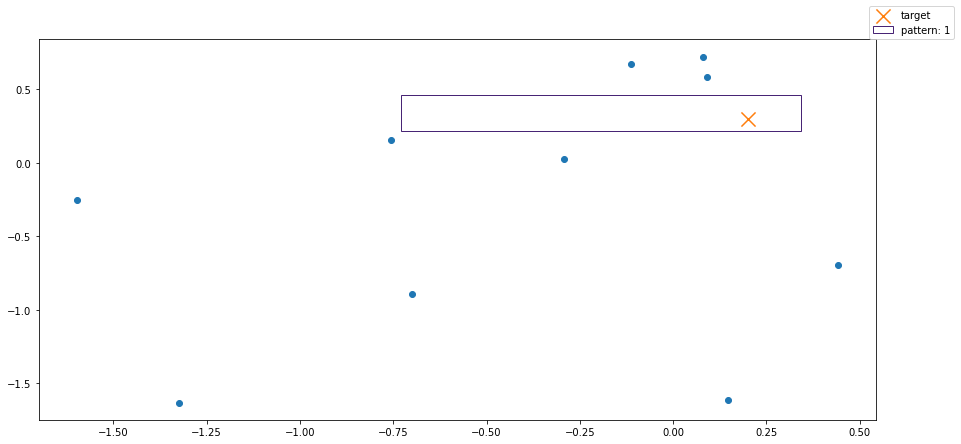

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [ ]:
# min x , min y 
# max x , max y
rare_pattern_detect.largest_bounding_area

array([[-1.60827543, -1.64028223],
       [ 0.45044087,  0.73305149]])

In [ ]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [ ]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.3, epsilon=0.1, delta=0.1)

In [ ]:
testing_points = multivariate_normal.rvs(size=(2,2))
testing_points

array([[ 1.09971639, -0.45657853],
       [-1.37976428, -1.26650663]])

In [ ]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0.2)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 110 constraints (1 nonlinear) and 0 disjunctions, with 61 variables, of which 55 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.27245e-07            inf   -5.27245e-07      nan%      0.18
         1              MILP            4.9756            inf         4.9756      nan%      0.21
NLP subproblem was locally infeasible.
Solving feasibility problem
MILP solver reported feasible solution, but not guaranteed to be optimal.
         2              MILP            4.9756            inf         4.9756      nan%      0.48
*        2         Fixed NLP           1.79189        1.79189         4.9756   177.67%      0.60
MILP solver reported feasible solution, but not guaranteed to be optimal.
         3              MILP            4.9756        1.79189         4.9756   177.67%      0.63
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 1.791894493623862  Dual Bound: 4.97559815312015


[True, False]

pattern:  None


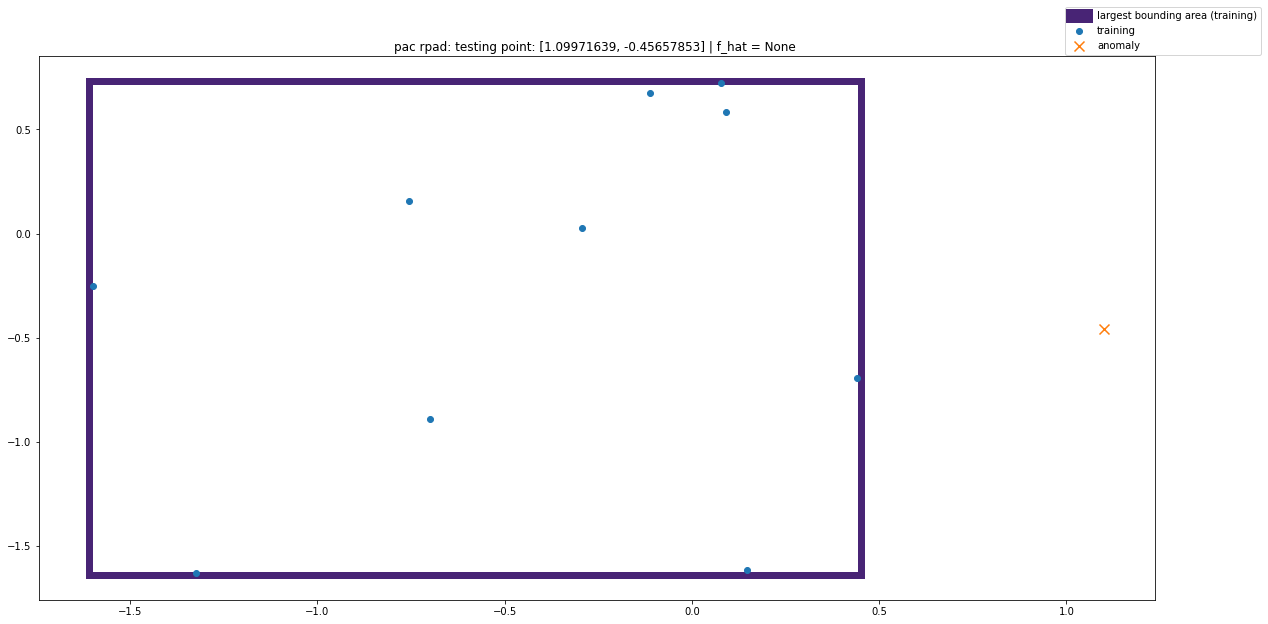

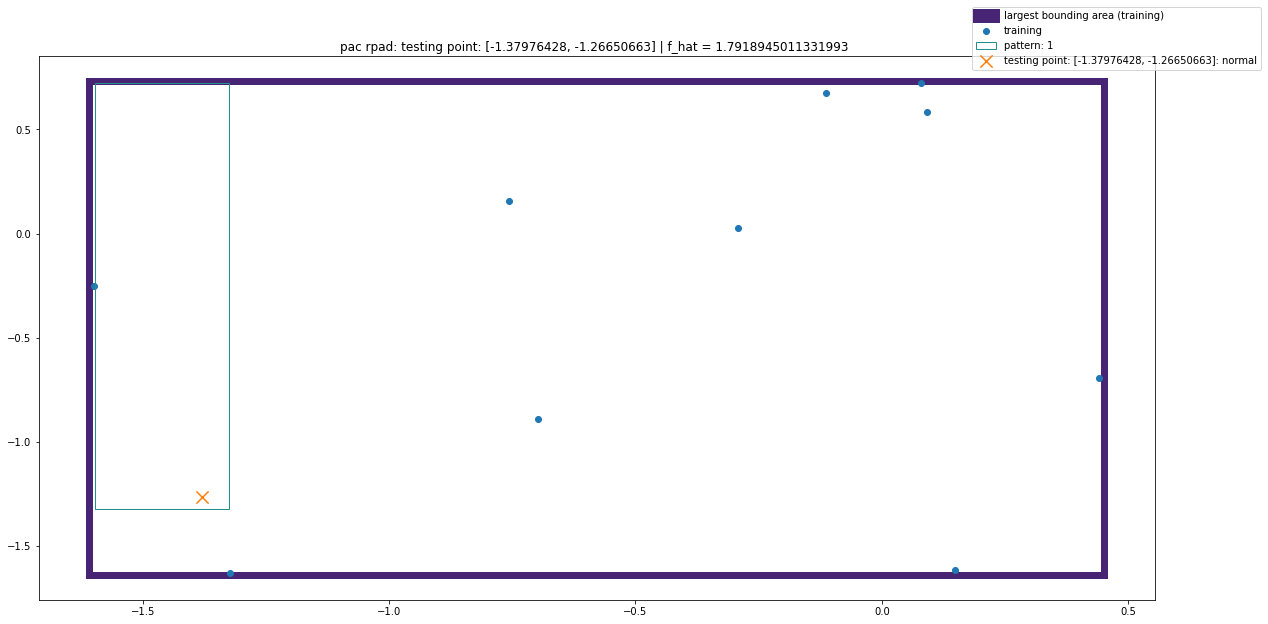

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        print("pattern: ", pattern)
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [ ]:
# TODO: TEST !!!
    # - implemenent simple test (4 points where the correct answer is already known)
    #   - find the correct pattern, respect the boundaries in each of the dim, use simplest training set and simplest test point 
    #   - training set: (0.0,0.0) (2.0,0.0) (0.0,2.0) (2.0,2.0)
    #   - testing point: (1.0,1.0) 
    #   - unit test to test the functionnalities of the functions 
        # run solver and compare with the expected result 
            # - for the pattern intervals 
            # - for the min area 
            # - for the largest_bounding_area
    
# - one important thing is to think about how to configure the min_area value depending on the dataset.
    # min area: fraction of the bounding area, makes it dependent on the number of training points!  

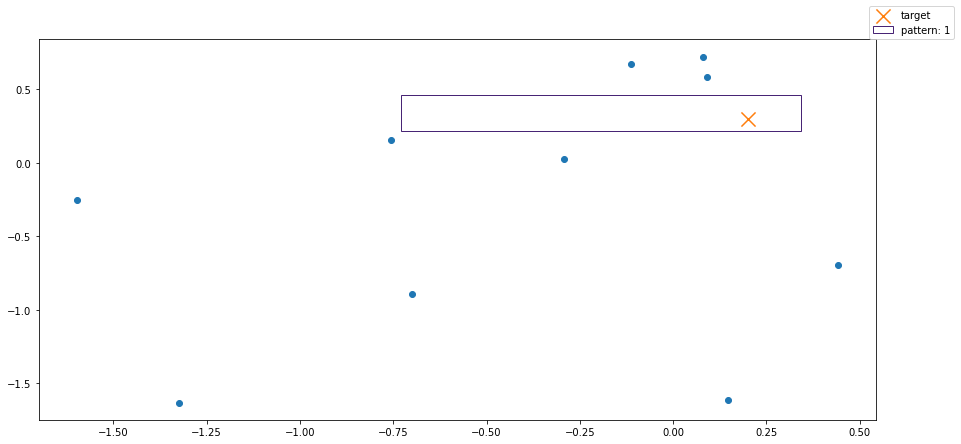

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

cmap = plt.get_cmap('viridis')

def draw2dpattern(interval, ax, index, total):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(index/total),
        label=f"pattern: {index}"
        )
    )


plt.scatter(x=training_points[:,0], y=training_points[:,1])
plt.scatter(x=point_to_be_classified[0], y=point_to_be_classified[1], marker="x",  s=200, label="target") 
for i, p in enumerate(included_points):
    plt.scatter(x=p[0], y=p[1], marker="o", s=200, label=f"included point: {np.argwhere(training_points == p)[0,0]}")
ax = plt.gca()
draw2dpattern(intervals, ax, 1, len(training_points))
ax.legend(bbox_to_anchor=(1.1, 1.1))
plt.show()

In [ ]:
# min x , min y 
# max x , max y
intervals, rare_pattern_detect.largest_bounding_area

(array([[-0.72953932,  0.34229958],
        [ 0.21864858,  0.45830881]]),
 array([[-1.60827543, -1.64028223],
        [ 0.45044087,  0.73305149]]))

In [ ]:
from typing import Callable
import numpy as np
import json

class PACRPAD:
    """
    Superclass for all PAC-RPAD implementations
    """
    def __init__(self, tau, epsilon, delta):
        self.tau = tau
        self.epsilon = epsilon
        self.delta = delta
        self.find_min_f_hat = None

    def has_rare_pattern(self, point) -> bool:
        results = self.find_min_f_hat[f"{point}"]
        print("f_hat: ", results)
        print("mu: ", self.tau + self.epsilon / 2)
        if results['objective'] != None:
            results['anomaly'] = results['objective'] <= self.tau + self.epsilon / 2
        return results['anomaly']


class AxisAlignedHyperRectanglePACRPAD(PACRPAD):
    def __init__(self, tau, epsilon, delta):
        super().__init__(tau, epsilon, delta)
        self.solver = None 
        self.training_points = None
        self.testing_points = None

    def construct_f_hat_estimator(self, training_points, testing_points, min_area=0.01):
        def _contains(point: np.ndarray, largest_bounding_area) -> bool:
            return all((largest_bounding_area[0,:] <= point.T) & (point.T <= largest_bounding_area[1,:]))

        self.training_points = training_points
        self.testing_points = testing_points
        dict_results = {}

        # Check if testing points lie within the initial pattern bounds
        dummy_solver = RarePatternDetect(self.training_points, min_area=min_area)
        candidates = []
        for idx, test_p in enumerate(self.testing_points):
            # TODO: extract the largest_bounding_area outside of the solver 
            # TODO: extract the functionalities of evaluating to has rare pattern 
            contained = _contains(test_p, dummy_solver.largest_bounding_area)
            if contained:
                # if yes then add testing_points to ensemble of points used to create the pattern space 
                candidates = [train_p for train_p in self.training_points]
                candidates = np.array(candidates)
                candidates = np.append(candidates, [test_p], axis=0)
                self.solver = RarePatternDetect(candidates, min_area=min_area)
                objective = self.solver.classify(test_p)
                intervals = self.solver.extract_pattern()
                included_points = self.solver.extract_points_included_in_pattern()
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : None,
                    'objective' : objective, 
                    'pattern' : intervals.tolist(), 
                    'included points' : included_points.tolist()
                }
            else:
                # else: anomaly = True
                dict_results[f"{test_p}"] =  {
                    'index' : idx,
                    'anomaly' : True,
                    'objective' : None, 
                    'pattern' : None, 
                    'included points' : None
                }

        with open('minlp_results.json', 'w') as fp:
            json.dump(dict_results, fp, indent=4)

        self.find_min_f_hat = dict_results

In [ ]:
exact = AxisAlignedHyperRectanglePACRPAD(tau=0.1, epsilon=0.1, delta=0.1)

In [ ]:
testing_points = multivariate_normal.rvs(size=(20,2))
testing_points

array([[ 1.27695949,  1.15587565],
       [-0.70350805,  1.31341521],
       [-1.55631494, -0.36950873],
       [-1.47169082, -0.75699573],
       [-1.4764998 ,  0.54506253],
       [ 1.12324341,  0.35641627],
       [-1.07731197,  0.13600671],
       [ 0.51714607, -1.12296679],
       [-0.14662959,  0.74065433],
       [-0.81526658, -1.5336447 ],
       [-0.08059456,  0.79957315],
       [-0.82611591,  0.40423332],
       [ 0.7619833 , -0.49579955],
       [-0.61884398, -0.95142278],
       [-1.28534851,  0.7109265 ],
       [ 0.37100407, -0.85576341],
       [ 0.45012638,  1.21979577],
       [ 0.33424361,  0.06291327],
       [ 0.11115091, -0.20189259],
       [-2.5723921 , -0.06546083]])

In [ ]:
exact.construct_f_hat_estimator(training_points, testing_points, min_area=0.2)
labels_pac_minlp = [exact.has_rare_pattern(x) for x in exact.testing_points]
labels_pac_minlp

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 110 constraints (1 nonlinear) and 0 disjunctions, with 61 variables, of which 55 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)



adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.27243e-07            inf   -5.27243e-07      nan%      0.35
         1              MILP           4.97558            inf        4.97558      nan%      0.40
NLP subproblem was locally infeasible.
Solving feasibility problem
MILP solver reported feasible solution, but not guaranteed to be optimal.
         2              MILP           4.97558            inf        4.97558      nan%      0.95
*        2         Fixed NLP           2.59457        2.59457        4.97558    91.77%      1.09
MILP solver reported feasible solution, but not guaranteed to be optimal.
         3              MILP           4.97558        2.59457        4.97558    91.77%      1.12
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 2.5945665588640847  Dual Bound: 4.9755758353061


adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.48159e-07            inf   -5.48159e-07      nan%      0.22
         1              MILP           4.99153            inf        4.99153      nan%      0.26
NLP subproblem was locally infeasible.
Solving feasibility problem
MILP solver reported feasible solution, but not guaranteed to be optimal.
         2              MILP           4.99153            inf        4.99153      nan%      0.65
*        2         Fixed NLP           2.50795        2.50795        4.99153    99.03%      0.76
MILP solver reported feasible solution, but not guaranteed to be optimal.
         3              MILP           4.99153        2.50795        4.99153    99.03%      0.80
*        3         Fixed NLP           1.31365        1.31365        4.99153   279.97%      1.00
MILP solver reported feasible solution, but not guaranteed to be optimal.
         4              MILP           4.99153        1.31365        4.99153   279.97%      1.05
Cycling happens after 4 main ite

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP       -5.2724e-07            inf    -5.2724e-07      nan%      0.23
         1              MILP           4.97555            inf        4.97555      nan%      0.27
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP           4.97555            inf        4.97555      nan%      0.51
*        2         Fixed NLP           1.79189        1.79189        4.97555   177.67%      0.63
         3              MILP           4.97555        1.79189        4.97555   177.67%      0.66
*        3         Fixed NLP           1.79189        1.79189        4.97555   177.67%      0.77
         4              MILP           4.97555        1.79189        4.97555   177.67%      0.80
Cycling happens after 4 main iterations. The same combination is obtained in iteration 3 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 1.

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.27246e-07            inf   -5.27246e-07      nan%      0.19
         1              MILP            4.9756            inf         4.9756      nan%      0.23
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP            4.9756            inf         4.9756      nan%      0.50
*        2         Fixed NLP           1.88769        1.88769         4.9756   163.58%      0.63
         3              MILP            4.9756        1.88769         4.9756   163.58%      0.66
         3         Fixed NLP           3.83499        1.88769         4.9756   163.58%      0.77
         4              MILP            4.9756        1.88769         4.9756   163.58%      0.80
Cycling happens after 4 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 1.

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP      -5.27249e-07            inf   -5.27249e-07      nan%      0.36
         1              MILP           4.97564            inf        4.97564      nan%      0.40
*        1         Fixed NLP           1.68099        1.68099        4.97564   196.00%      0.52
         2              MILP           4.97564        1.68099        4.97564   196.00%      0.56
*        2         Fixed NLP          0.995811       0.995811        4.97564   399.66%      0.68
         3              MILP           4.97564       0.995811        4.97564   399.66%      0.71
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 0.9958107217839737  Dual B

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP       -5.4816e-07            inf    -5.4816e-07      nan%      0.18
         1              MILP           4.99153            inf        4.99153      nan%      0.22
*        1         Fixed NLP           4.18608        4.18608        4.99153    19.24%      0.36
         2              MILP           4.99153        4.18608        4.99153    19.24%      0.39
*        2         Fixed NLP           1.19447        1.19447        4.99153   317.89%      0.51
         3              MILP           4.99153        1.19447        4.99153   317.89%      0.54
         3         Fixed NLP           1.25105        1.19447        4.99153   317.89%      0.64
         4              MILP           4.99153        1.19447        4.99153   317.89%      0.67
Cycling happens after 4 main iterations. The same combination is obtained in iteration 3 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final 

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP       -5.2725e-07            inf    -5.2725e-07      nan%      0.18
         1              MILP           4.97564            inf        4.97564      nan%      0.22
*        1         Fixed NLP           1.37374        1.37374        4.97564   262.20%      0.36
         2              MILP           4.97564        1.37374        4.97564   262.20%      0.39
Cycling happens after 2 main iterations. The same combination is obtained in iteration 1 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 1.3737357576128695  Dual Bound: 4.97564060889401
 Primal integral          :    0.0000 
 Dual integral            :    0.8989 
 Primal-dual gap integral :    0.8989 
---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
------

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.27242e-07            inf   -5.27242e-07      nan%      0.18
         1              MILP           4.97557            inf        4.97557      nan%      0.22
*        1         Fixed NLP           2.11263        2.11263        4.97557   135.52%      0.34
         2              MILP           4.97557        2.11263        4.97557   135.52%      0.37
*        2         Fixed NLP           1.19314        1.19314        4.97557   317.01%      0.50
         3              MILP           4.97557        1.19314        4.97557   317.01%      0.54
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 1.1931401122707752  Dual Bound: 4.97557064670585
 Primal integral          :    0.2879 
 Dual integral            :    0.9056 
 Primal-dual gap integral :    1.1935 


adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.27263e-07            inf   -5.27263e-07      nan%      0.18
         1              MILP           4.97576            inf        4.97576      nan%      0.23
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP           4.97576            inf        4.97576      nan%      0.57
*        2         Fixed NLP           2.50672        2.50672        4.97576    98.50%      0.70
         3              MILP           4.97576        2.50672        4.97576    98.50%      0.74
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 2.50672358313602  Dual Bound: 4.97576130032522
 Primal integral          :    0.0000 
 Dual integral            :    0.9186 
 Primal-dual gap integral :    0.9186 
--------------------------------

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.27261e-07            inf   -5.27261e-07      nan%      0.20
         1              MILP           4.97574            inf        4.97574      nan%      0.24
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP           4.97574            inf        4.97574      nan%      0.69
*        2         Fixed NLP           3.83499        3.83499        4.97574    29.75%      0.82
         3              MILP           4.97574        3.83499        4.97574    29.75%      0.86
*        3         Fixed NLP           3.83311        3.83311        4.97574    29.81%      1.01
         4              MILP           4.97574        3.83311        4.97574    29.81%      1.04
Cycling happens after 4 main iterations. The same combination is obtained in iteration 3 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 3.

adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  0
adjust_largest_pattern_bounds:  1
adjust_largest_pattern_bounds:  1


         -       Relaxed NLP      -5.27256e-07            inf   -5.27256e-07      nan%      0.21
         1              MILP            4.9757            inf         4.9757      nan%      0.25
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP            4.9757            inf         4.9757      nan%      0.54
*        2         Fixed NLP           3.88585        3.88585         4.9757    28.05%      0.64
         3              MILP            4.9757        3.88585         4.9757    28.05%      0.68
Cycling happens after 3 main iterations. The same combination is obtained in iteration 2 This issue happens when the NLP subproblem violates constraint qualification. Convergence to optimal solution is not guaranteed.
Final bound values: Primal Bound: 3.8858549152135913  Dual Bound: 4.97569630909275
 Primal integral          :    0.0000 
 Dual integral            :    1.0575 
 Primal-dual gap integral :    1.0575 


f_hat:  {'index': 0, 'anomaly': True, 'objective': None, 'pattern': None, 'included points': None}
mu:  0.15000000000000002
f_hat:  {'index': 1, 'anomaly': True, 'objective': None, 'pattern': None, 'included points': None}
mu:  0.15000000000000002
f_hat:  {'index': 2, 'anomaly': None, 'objective': 2.594566566358181, 'pattern': [[-1.5972754348751619, -1.3247553080509473], [-0.6912324127026627, 0.7230514961069597]], 'included points': [[-1.5563149434915409, -0.36950873159197484]]}
mu:  0.15000000000000002
f_hat:  {'index': 3, 'anomaly': None, 'objective': 1.3136543171736497, 'pattern': [[-1.5982754350871833, -0.7571714883594602], [-1.5982754334119251, -0.6932323957950606]], 'included points': [[-1.4716908214332538, -0.7569957330858886]]}
mu:  0.15000000000000002
f_hat:  {'index': 4, 'anomaly': None, 'objective': 1.7918945011474392, 'pattern': [[-1.5972754349101312, -1.3247553082330155], [-1.4787604053563372, 0.5690463961974068]], 'included points': [[-1.4764997952533923, 0.54506253273530

[True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True]

In [ ]:
exact.solver.largest_bounding_area.T

array([[-1.60827543,  0.45044087],
       [-1.64028223,  0.73305149]])

pattern:  None


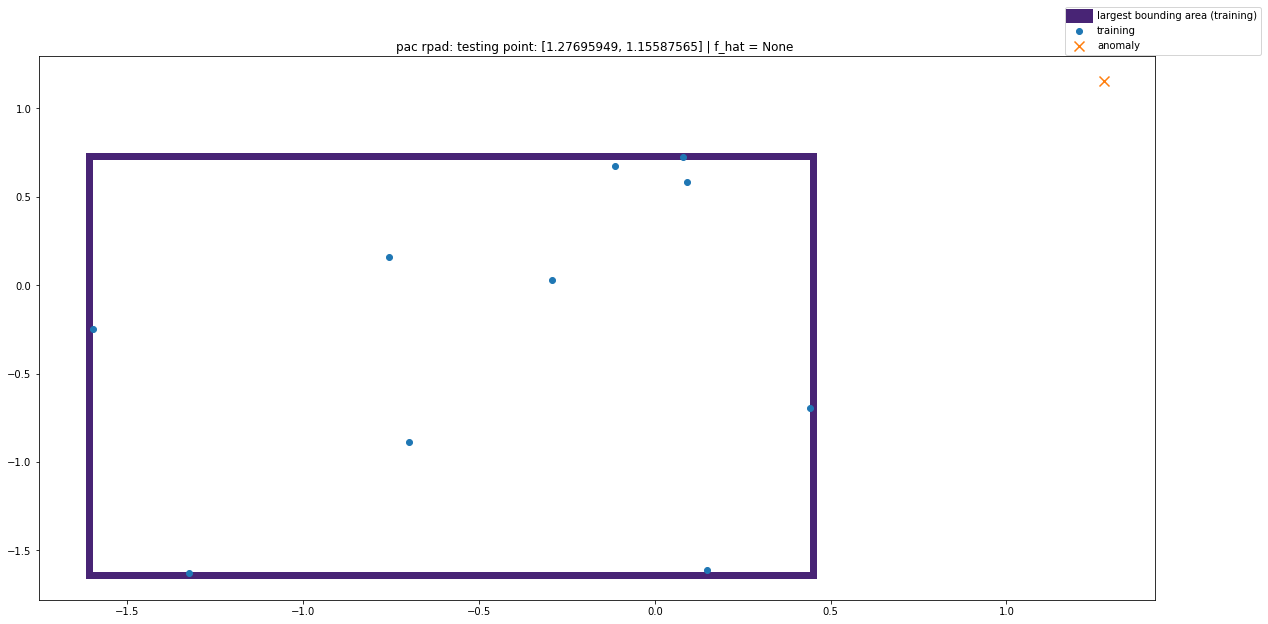

pattern:  None


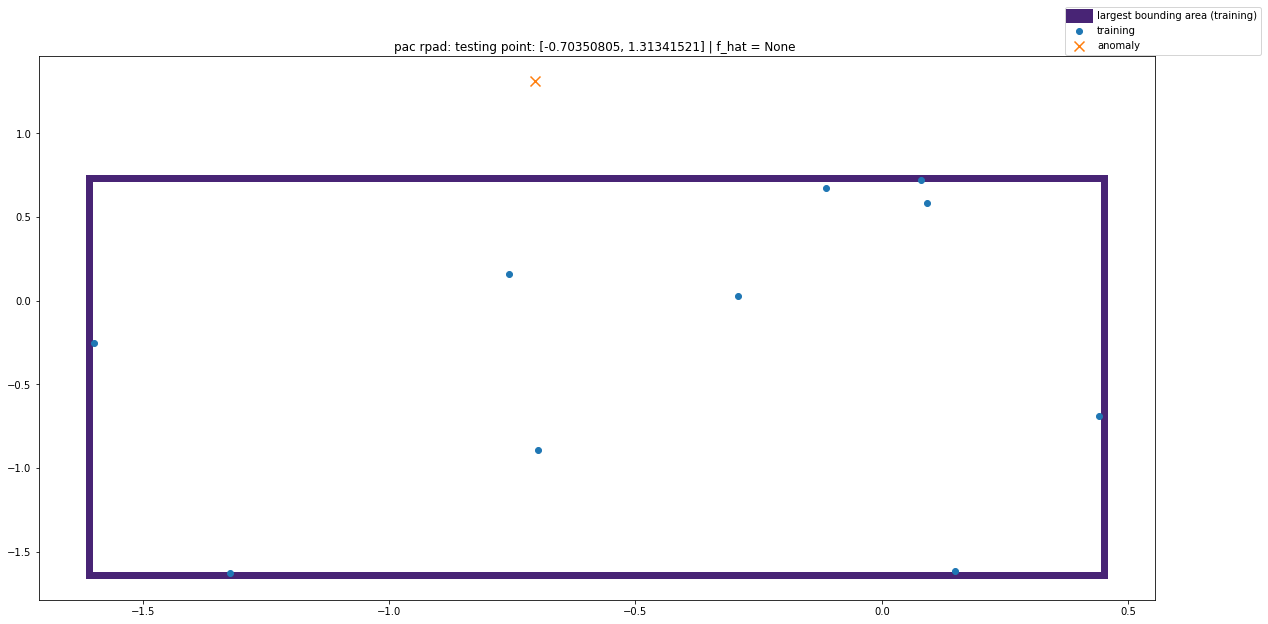

pattern:  [[-1.59727543 -1.32475531]
 [-0.69123241  0.7230515 ]]


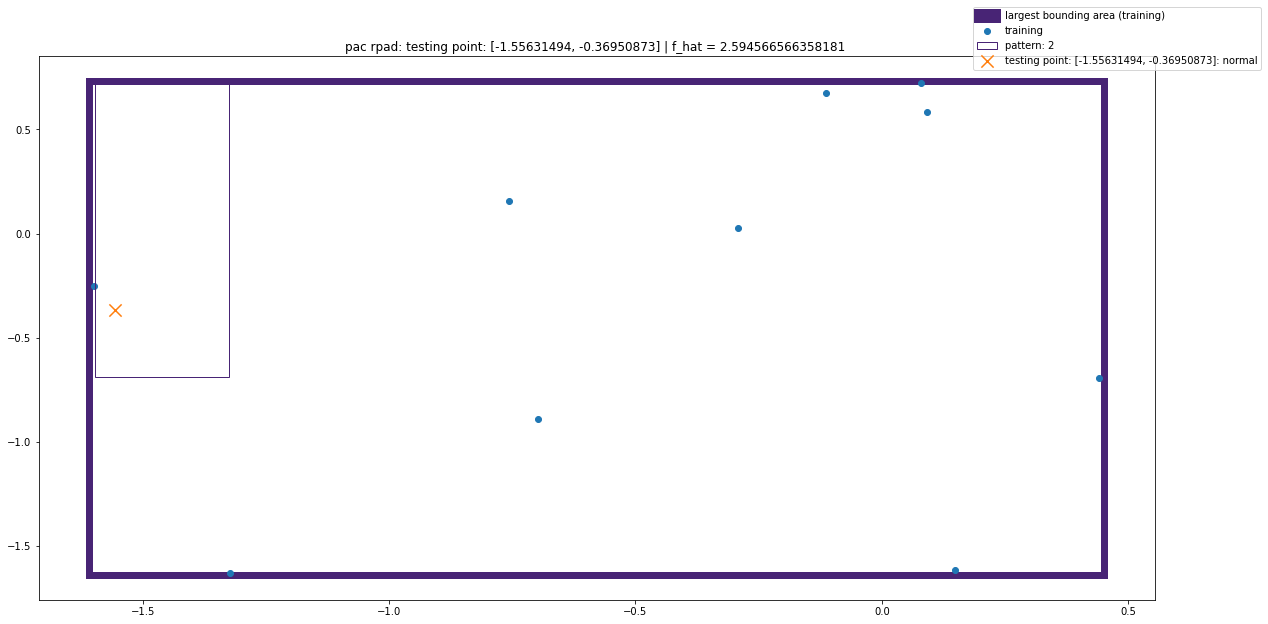

pattern:  [[-1.59827544 -0.75717149]
 [-1.59827543 -0.6932324 ]]


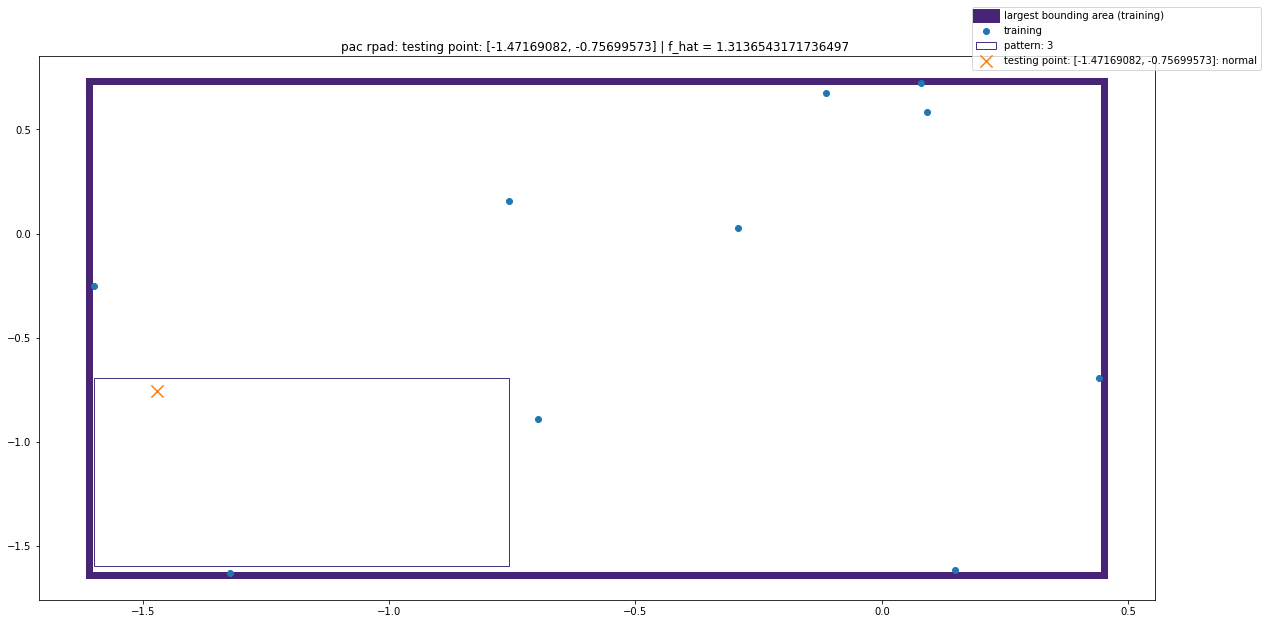

pattern:  [[-1.59727543 -1.32475531]
 [-1.47876041  0.5690464 ]]


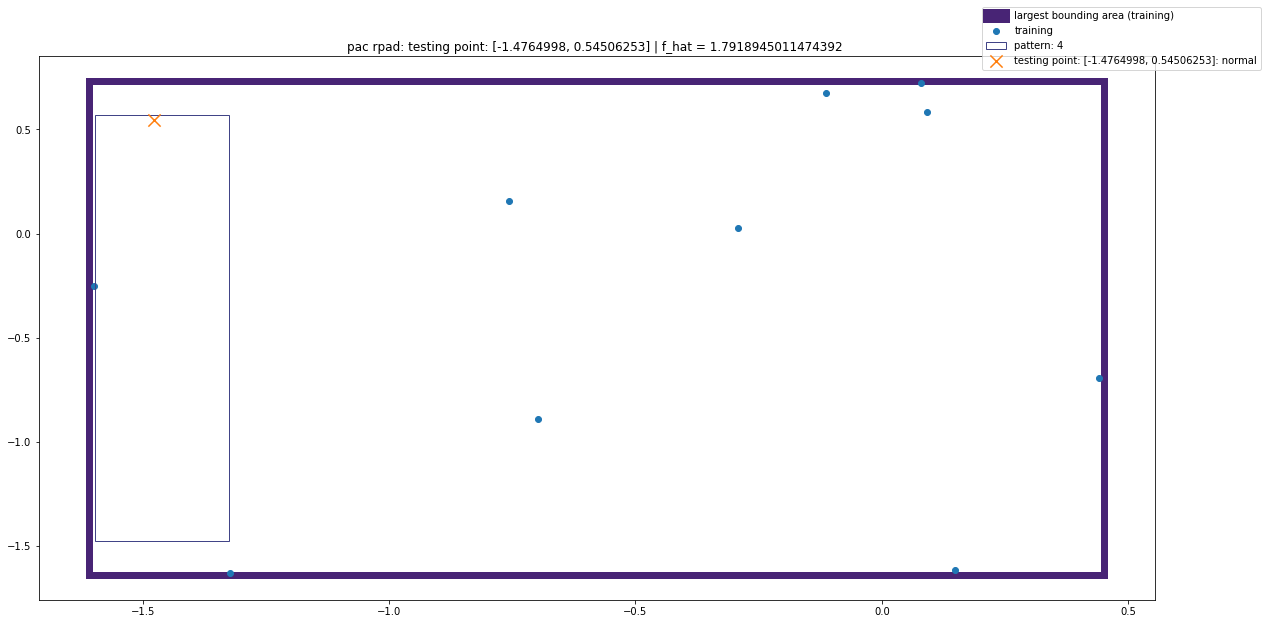

pattern:  None


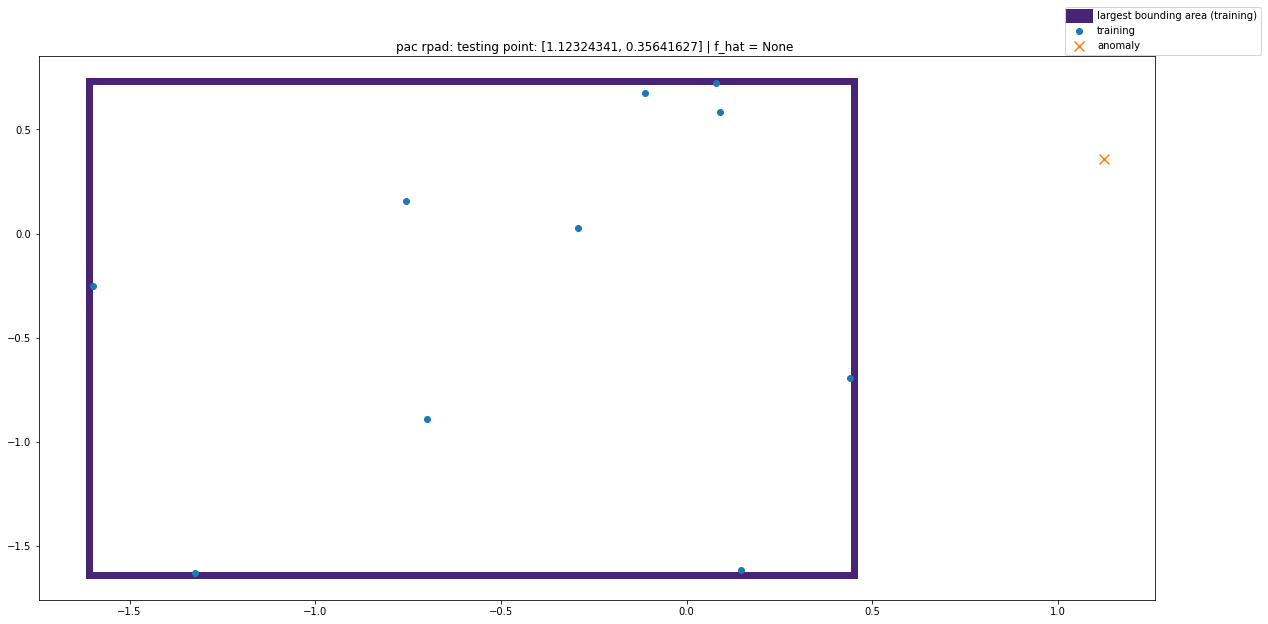

pattern:  [[-1.59827543 -0.29352944]
 [-0.24939911  0.15661645]]


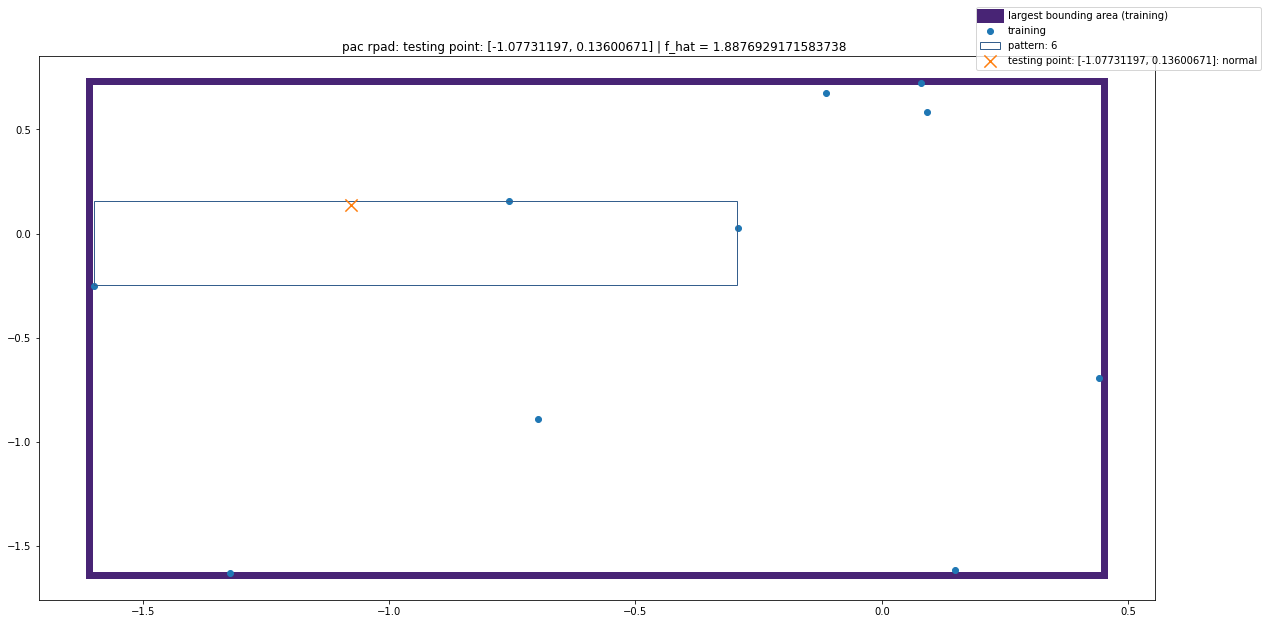

pattern:  None


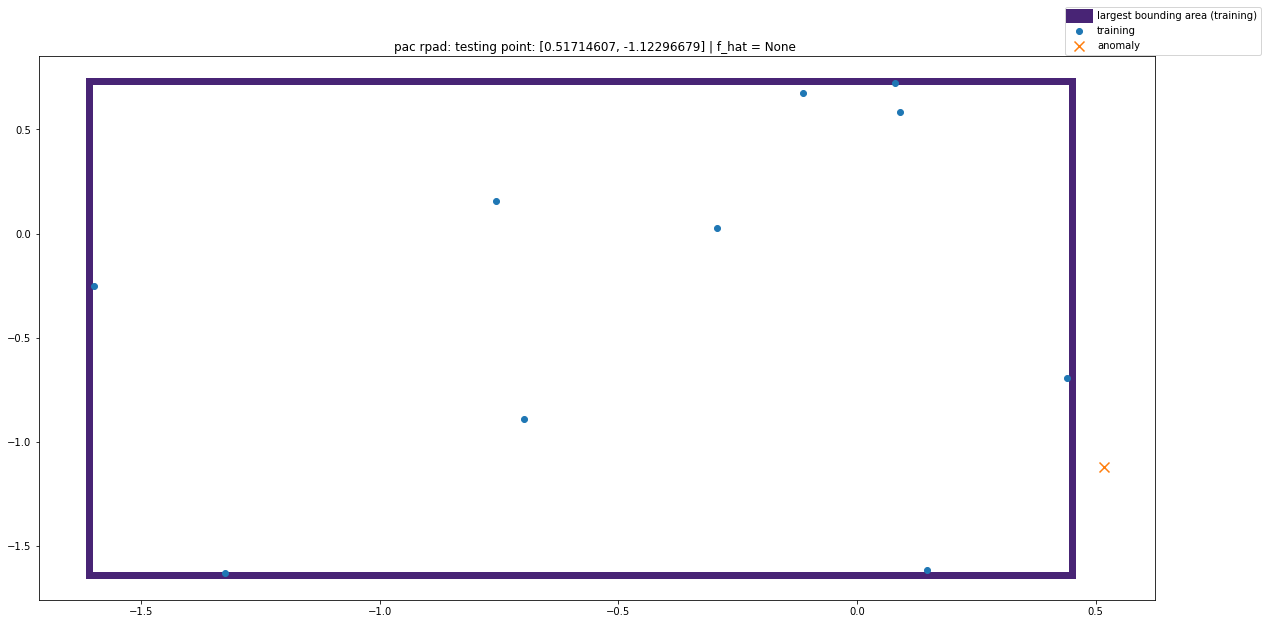

pattern:  None


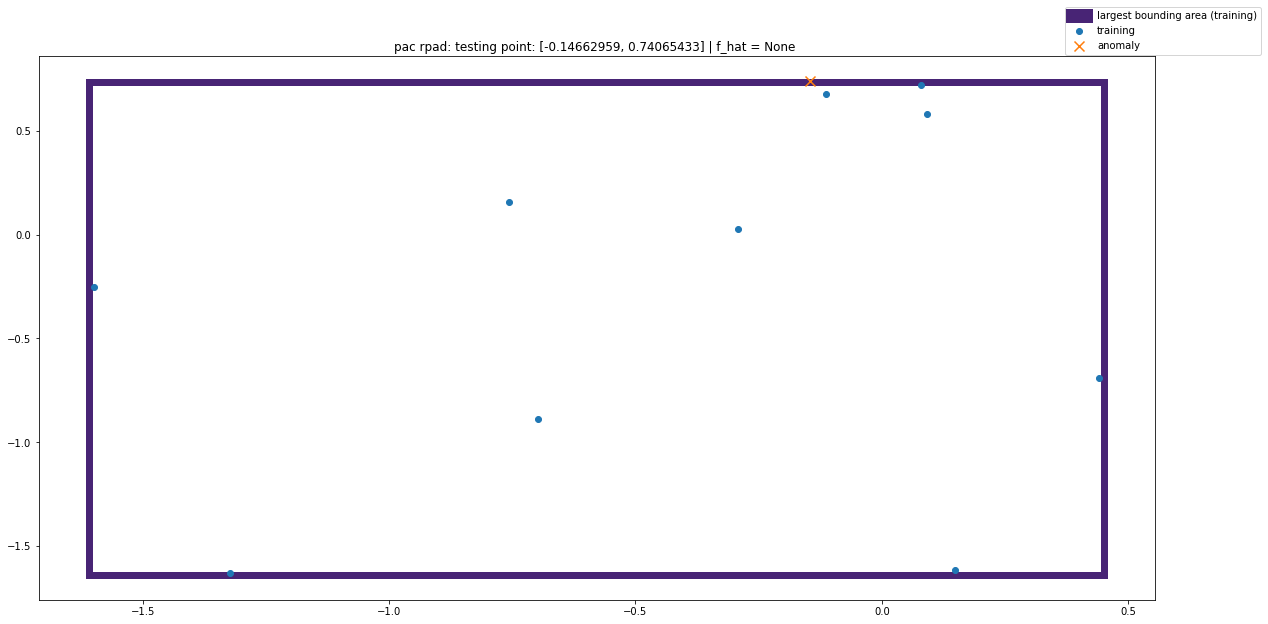

pattern:  [[-1.59727543  0.14750104]
 [-1.56887246 -0.99332201]]


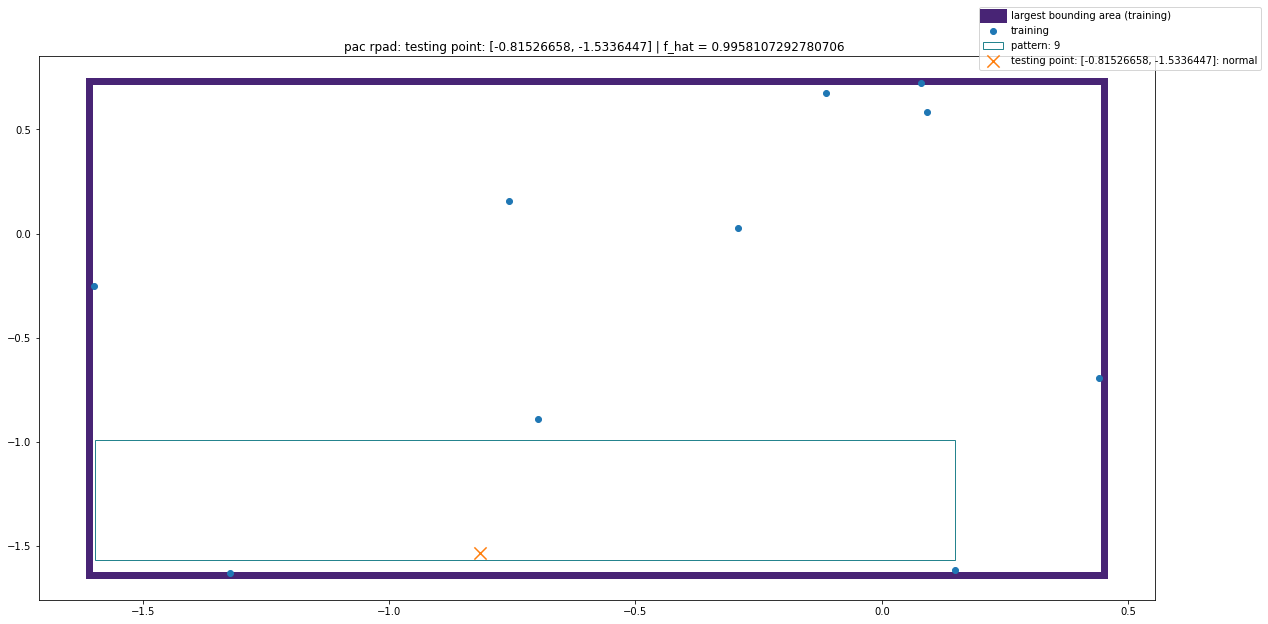

pattern:  None


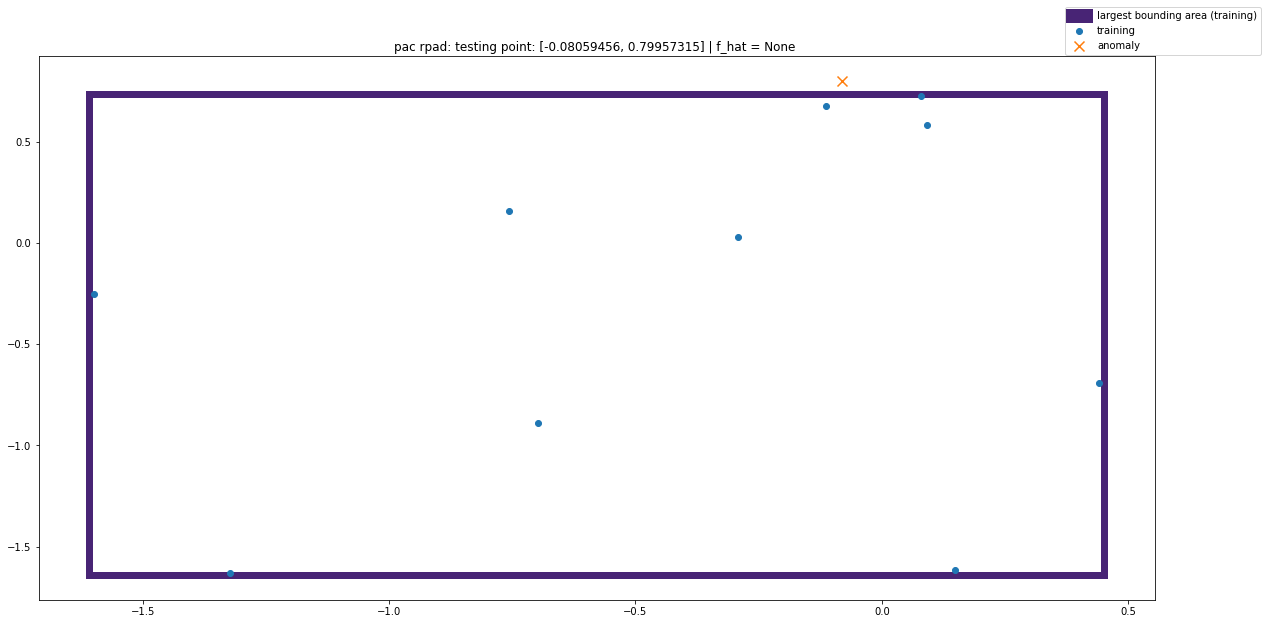

pattern:  [[-1.32275533 -0.75717149]
 [-1.00292775  0.47729524]]


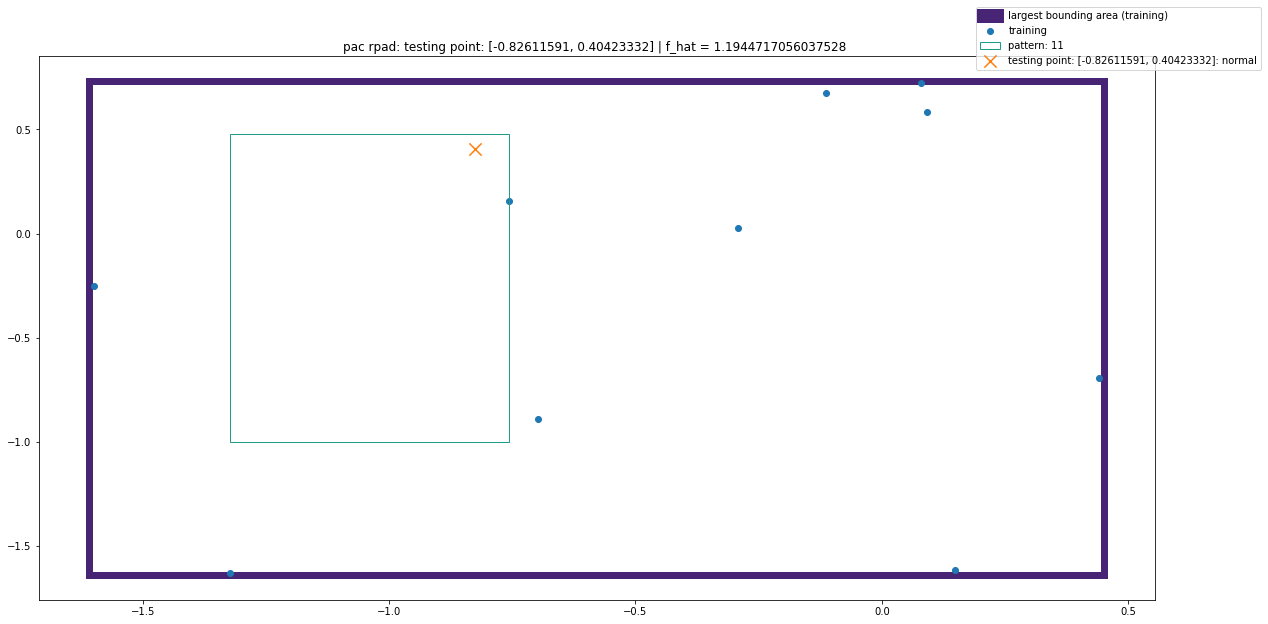

pattern:  None


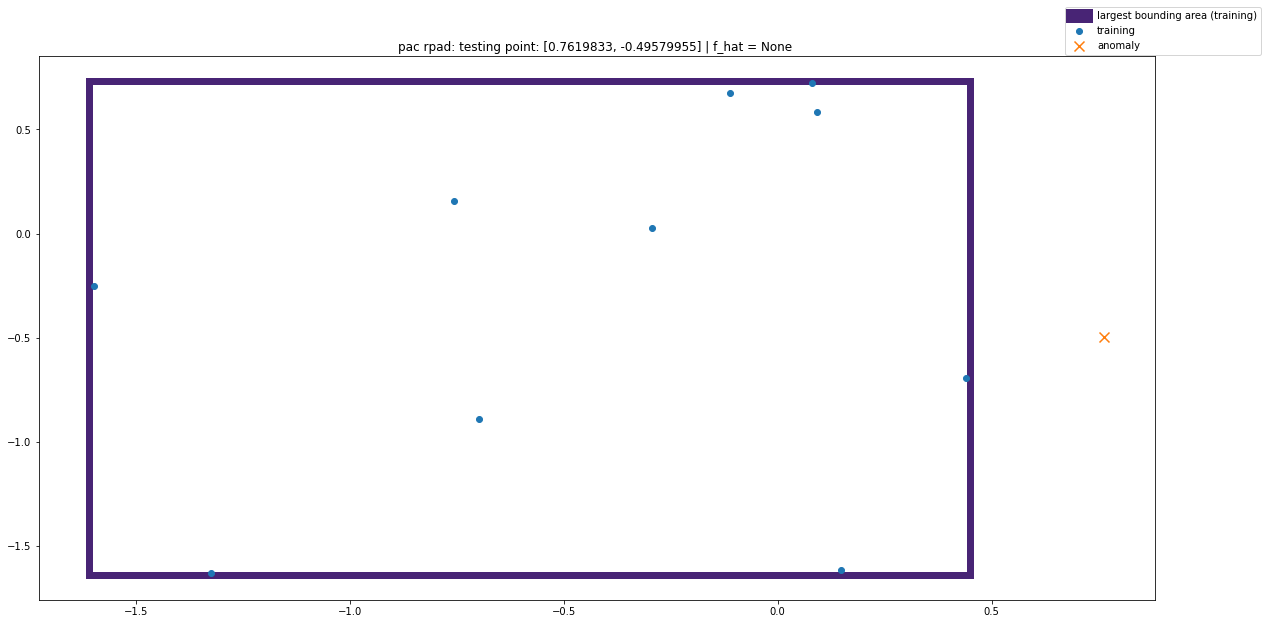

pattern:  [[-1.32275533 -0.29352944]
 [-1.59827543 -0.89100404]]


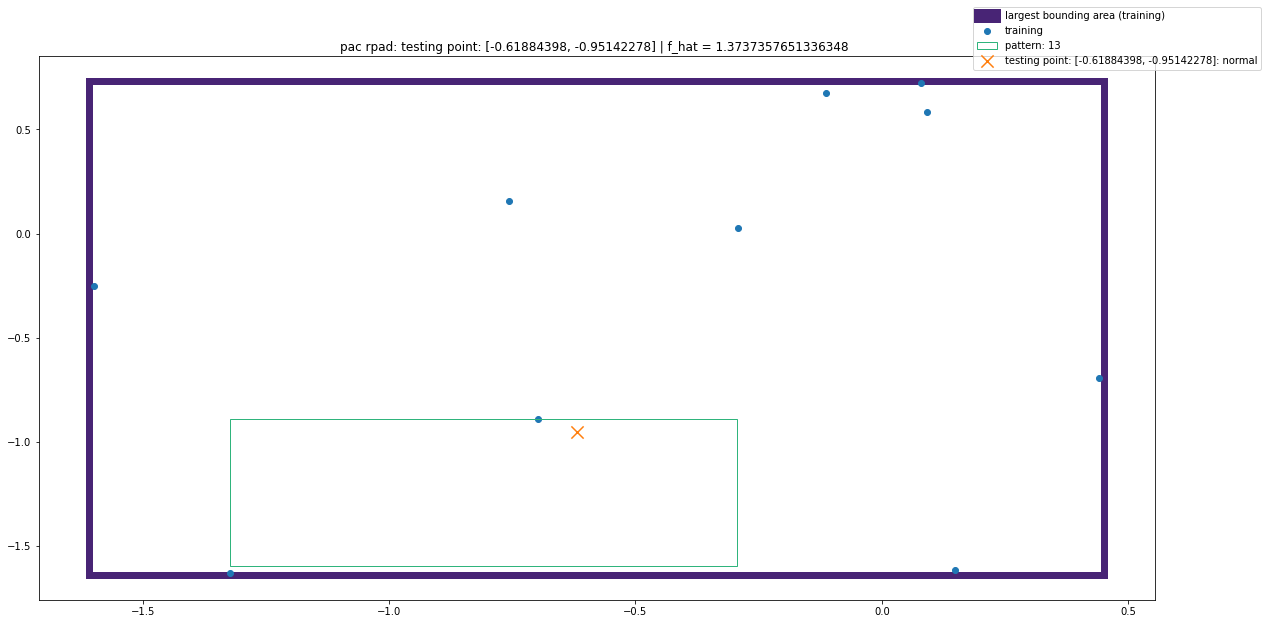

pattern:  [[-1.59827543 -0.11338445]
 [ 0.15861644  0.7230515 ]]


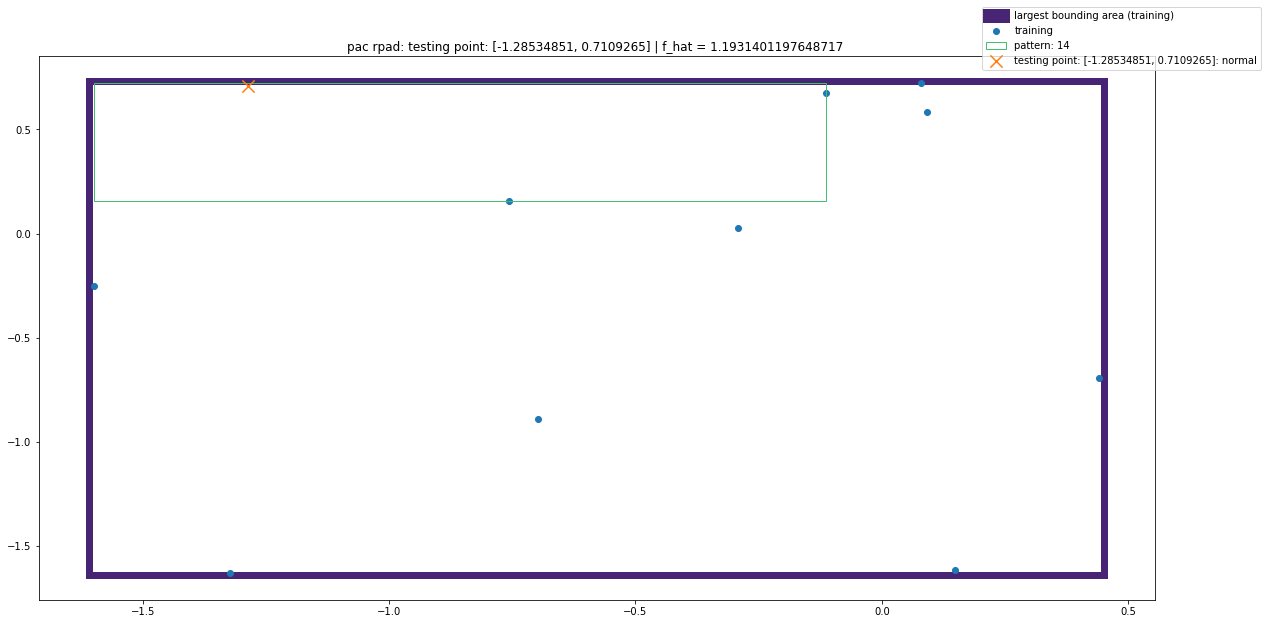

pattern:  [[-1.59827543  0.43944087]
 [-0.88900406 -0.69323239]]


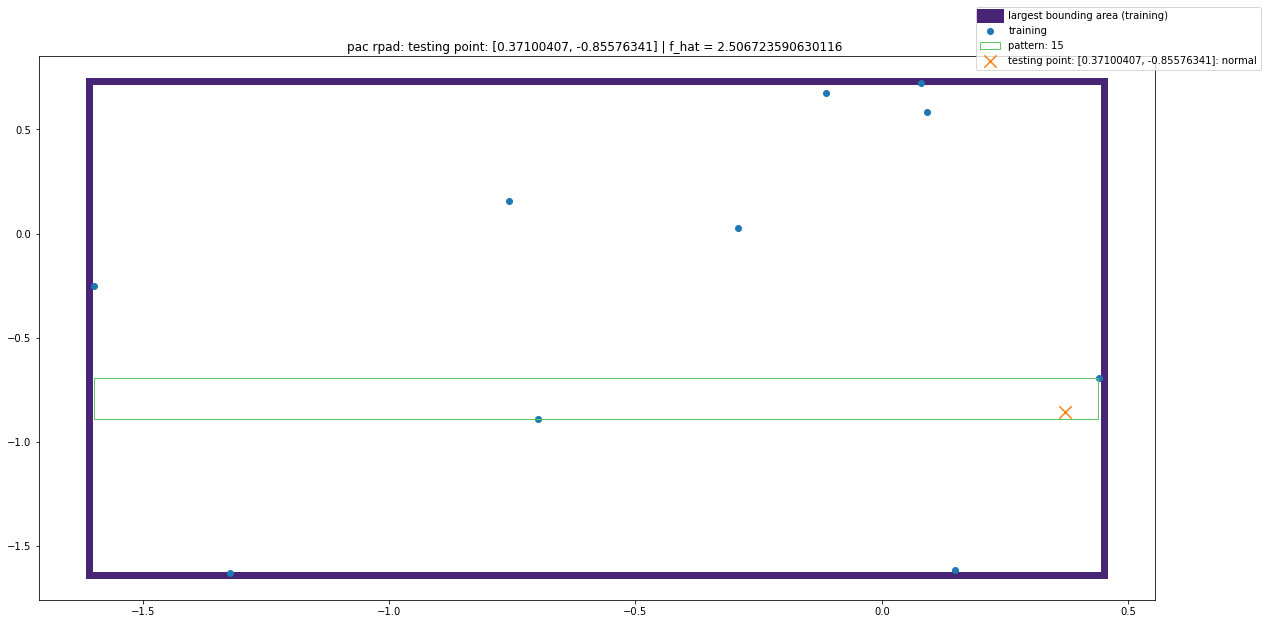

pattern:  None


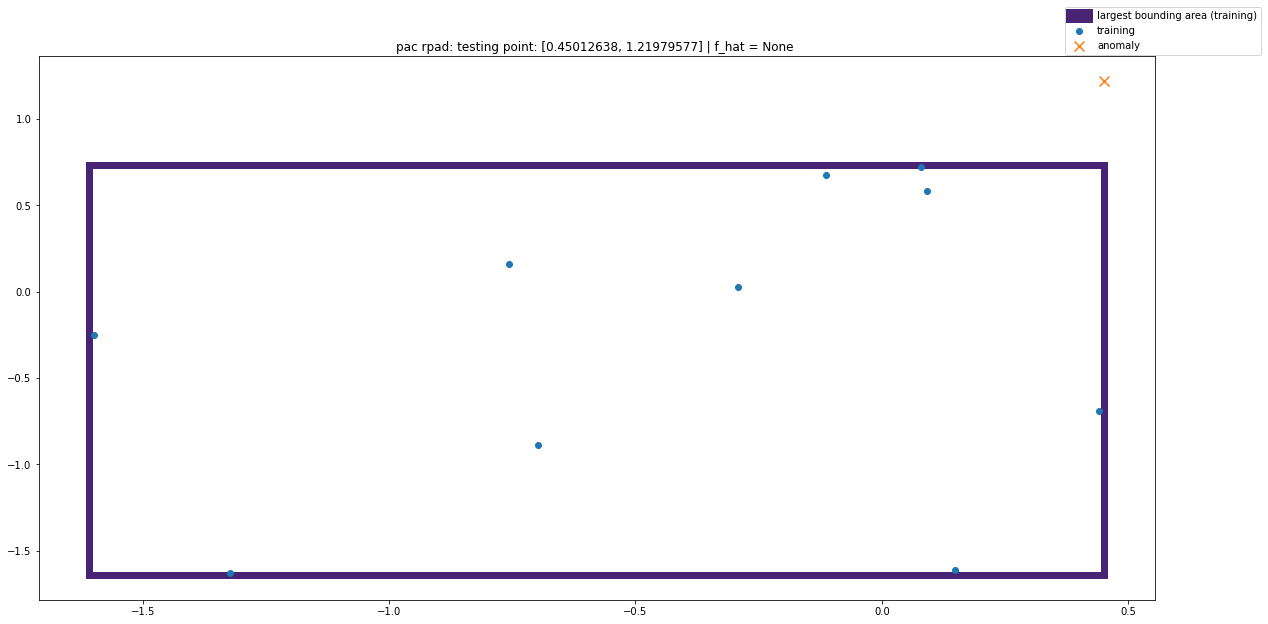

pattern:  [[-1.59827543  0.44044087]
 [ 0.02865121  0.15661646]]


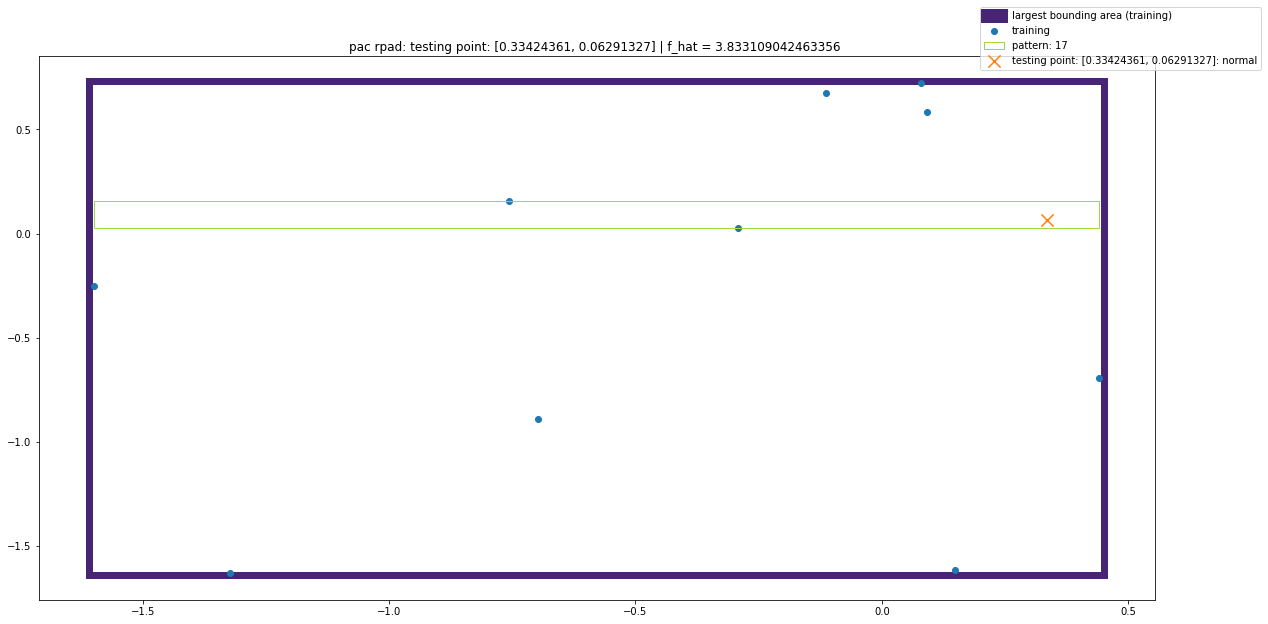

pattern:  [[-0.29152946  0.21576102]
 [-0.31373861  0.19355186]]


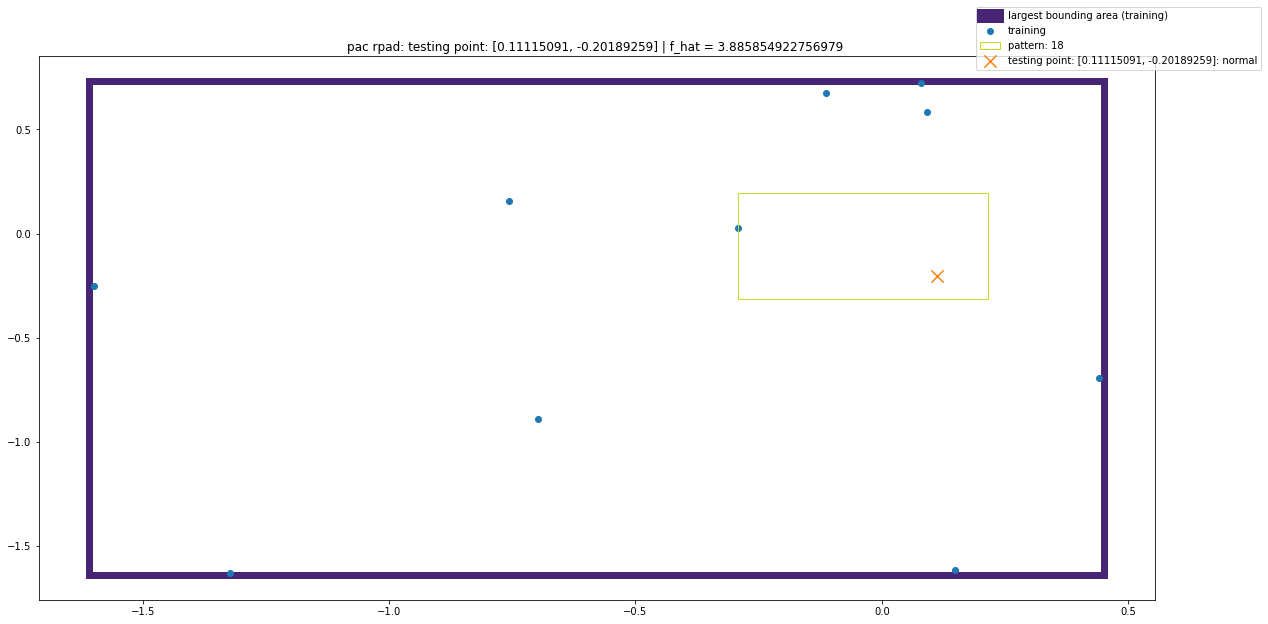

pattern:  None


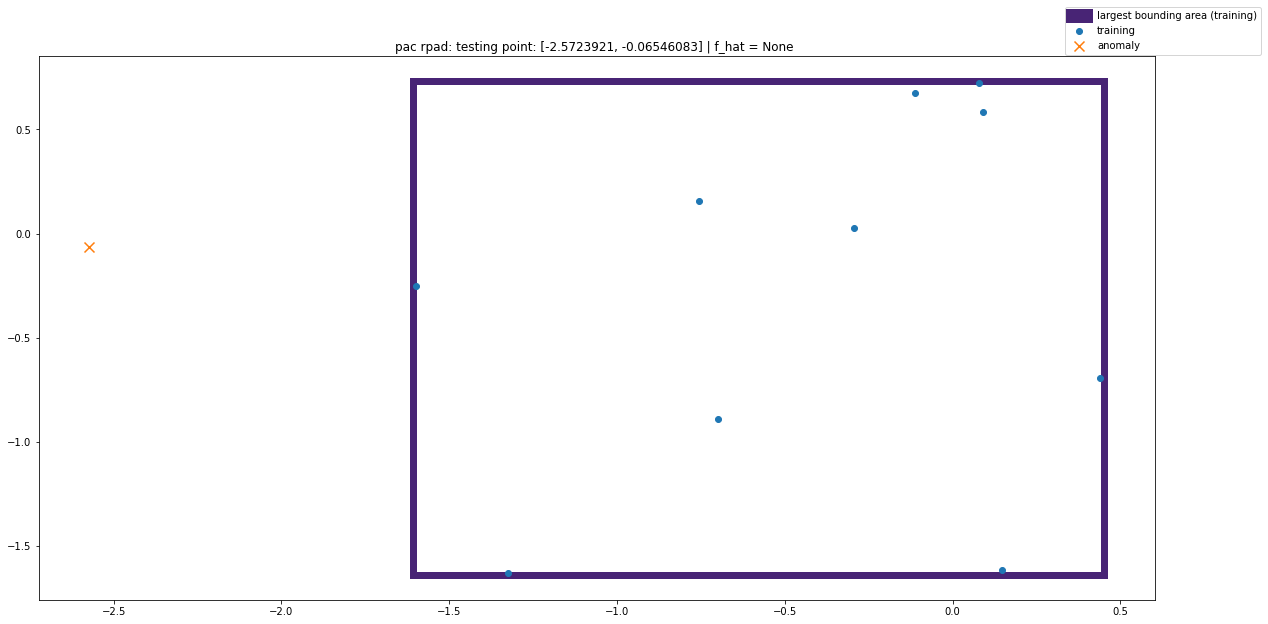

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
cmap = plt.get_cmap('viridis')


def draw_largest_bounding_area(interval, ax):
    ax.add_patch(patches.Rectangle(
        xy=(interval[0,0], interval[1,0]),
        width=interval[0,1] - interval[0,0],
        height=interval[1,1] - interval[1,0],
        facecolor='none',
        edgecolor=cmap(0.1),
        label= "largest bounding area (training)",
        linewidth=7.0
        )
    )


total = len(testing_points)
for i, (k,v) in enumerate(exact.find_min_f_hat.items()):
    ax = plt.gca()
    k = [float(x) for x in k[1:-1].split(" ") if x]
    point = k # exact.testing_points[i]
    draw_largest_bounding_area(exact.solver.largest_bounding_area.T, ax)
    ax.scatter(x=exact.training_points[:,0], y=exact.training_points[:,1], marker="o", label="training")
    pattern = np.array(v['pattern'])
    anomaly = v['anomaly']
    f_hat = v['objective']
    print("pattern: ", pattern)
    if anomaly:
        plt.scatter(x=k[0], y=k[1], marker="x", s=100, label="anomaly")
        if pattern.all() != None:
            draw2dpattern(pattern, ax, i, total)
    else:
        draw2dpattern(pattern, ax, i, total)
        ax.scatter(x=point[0], y=point[1], marker="x", s=150, label=f"testing point: {k}: normal")
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.title(f"pac rpad: testing point: {k} | f_hat = {f_hat} ")
    plt.show()


In [ ]:
# TODO: 
# - show to Paul: 
#     added a constraint_list to the model to enforce that the pattern's 
#     coordinates (the parameters of the calculated bounding pattern) don't overpass the 
#     boundaries (checked several examples in this notebook)

# There is still a bug with the interval_lengths that happens 
# when the model fails to calculate a pattern with postive reals (assumption)